In [1]:
import json
import re
from tqdm import tqdm

In [ ]:
with open("newsapec.json") as f:
    news_list = json.load(f)
    #load news

In [3]:
len(news_list)

9604

In [4]:
news_list[0]

{'title': 'BTS RM, 경주 APEC 기조연설자로 나선다',
 'author': None,
 'hostname': 'hani.co.kr',
 'date': '2025-10-27',
 'fingerprint': '7a6a656ab9fdbfaa',
 'id': None,
 'license': None,
 'comments': '',
 'raw_text': '기사를 읽어드립니다 0:00 광고 그룹 방탄소년단의 리더 알엠(RM)이 오는 29일 경주에서 열리는 아시아태평양경제협력체(APEC) 정상회의 부대 행사인 ‘아펙 시이오(APEC CEO) 서밋’에 기조연설자로 나선다. 27일 한겨레 취재 결과, 알엠은 서밋 2일 차인 29일 오후 3시5분부터 15분까지 약 10분간 문화 세션의 하나로 ‘아펙 지역의 문화창조산업과 케이(K)-컬처의 소프트파워’를 주제로 연설할 예정이다. 구체적인 발표 내용은 알려지지 않았다. 영어에 능숙한 알엠은 이번 연설에서 글로벌 재계 인사들을 대상으로 영어로 발표할 예정이다. 앞서 그는 유엔 총회와 미국 백악관 등 국제무대에서 영어로 연설한 바 있다. 광고 ‘아펙 시이오 서밋’은 21개 회원국 정상과 각국 기업인이 한자리에 모여 세계 경제의 주요 흐름과 혁신 산업의 방향을 논의하는 비즈니스 포럼이다. 올해 주제는 ‘비욘드, 비즈니스, 브리지’(Beyond, Business, Bridge)로, 케이팝 아티스트가 이 행사 연설자로 초청된 것은 이번이 처음이다. 한편, 방탄소년단이 속한 모회사 하이브는 이번 ‘아펙 시이오 서밋’의 공식 스폰서로 참여한다. 스폰서 기업 가운데 유일한 엔터테인먼트사로, 경주 예술의전당에 홍보 부스를 마련해 글로벌 비즈니스 현황을 소개하고, 산하 레이블 아티스트들의 성과와 케이팝 응원 문화를 상징하는 응원봉 등을 선보일 예정이다. 이정국 기자 jglee@hani.co.kr',
 'text': '기사를 읽어드립니다\n0:00\n광고\n그룹 방탄소년단의 리더 알엠(RM)이 오는 29일 경주에서 열리는 아시아태평양

In [ ]:
documents = []
invalid_line_patterns = re.compile(
    r"무단\s*전재|배포\s*금지|Copyrights|관련기사|기사\s*제보|여러분의 제보|카카오톡\s*:s*"
)
#find this pattern n remove all

for article in tqdm(news_list, mininterval=1):
    text = article["text"]

    lines = text.split("\n") #remove space
    filtered_lines = []

    for line in lines:
        line = " ".join(line.split()) #in line buat space

        # OOO 기자 패턴 제거
        line = re.sub(r"\w+ 기자", "", line) # buang reporter 
        # email 주소 제거
        line = re.sub(r"\w+@\w+\.\w+", "", line) #buang email
        # 뉴스에서 []는 [논산] [대구=뉴시스] 등 다양한 참조를 의미하므로 제거
        line = re.sub(r"\[.*\]", "", line) # buang symbol x perlu
        # (서울=연합뉴스) 같은 패턴 제거
        line = re.sub(r"\(.*=.*\)", "", line) #bunang symbol =
        # 2024.10.29/뉴스1 같은 패턴 제거
        line = re.sub(r"\d{4}\.\d{2}\.\d{2}/.*\b", "", line) # buang pattern tarikh-title

        # 공백 제거
        line = " ".join(line.split()) #buag space

        if invalid_line_patterns.search(line):
            # 무단전재, 배포금지 등이 포함된 문장 이후 문장들은 제외 #buang based on pattern
            break

        # 한국어가 50자 이상 포함된 경우만 포함
        num_korean_chars = len(re.findall(r"[ㄱ-ㅎ가-힣]", line))
        if num_korean_chars >= 10: #amik word yg more than 10 char only
            filtered_lines.append(line)

    text = "\n".join(filtered_lines) # letak space
    # 한국어가 10자 이상 포함된 경우만 포함
    num_korean_chars = len(re.findall(r"[ㄱ-ㅎ가-힣]", text))
    if num_korean_chars >= 50: #amik char yg 50 lebih je
        documents.append(text)

# 중복 제거
documents = list(set(documents)) # use set to avoid duplicate

100%|██████████| 9604/9604 [00:06<00:00, 1449.31it/s]


In [ ]:
from kiwipiepy import Kiwi # korean dict tokennize
from kiwipiepy.utils import Stopwords
from collections import Counter

kiwi = Kiwi()  # tokennize kiwi model_type="sbg"를 넣어주면 더 빠르지만 속도는 느림
stopwords = Stopwords() #load stopword

permited_pos = {"NNG", "NNP", "VA", "VV", "SL"} #take only meaning word type

document_tokens_list = []
word_freqs = Counter() 

#tokennize each word with kiwi, remove stop word
for document in tqdm(documents, mininterval=1):
    tokens = []
    for token in kiwi.tokenize(document, stopwords=stopwords):
        #keep only pos type word longer than 1 char
        if token.tag in permited_pos and len(token.form) > 1:
            tokens.append(token.form) # take word only in dict 

    #only keep dict have at least 10 meaning token
    if len(tokens) >= 10:
        document_tokens_list.append((document, tokens))
        word_freqs.update(tokens) # update req counter

In [ ]:
print(len(word_freqs))

# 여기 나온 빈도 중 의미 없는 단어들은 Stopword에 추가하면 좀 더 명확한 토픽 결과를 얻을 수 있다.
#see freq len for each word use most_common
for word, freq in word_freqs.most_common(50):
    print(word, freq)

32335
APEC 33037
정상 26762
대통령 22519
경주 18743
회의 17365
AI 15787
협력 12723
한국 12600
미국 10920
이번 10681
중국 10321
경제 9881
세계 9365
회담 8631
대표 8402
산업 8399
글로벌 7837
문화 7772
기술 7545
CEO 7522
행사 7462
정부 7436
열리 7342
국민 7076
트럼프 7038
밝히 6969
기업 6961
투자 6716
이재명 6516
가능 5980
외교 5837
지나 5294
국가 5114
관세 5092
회장 5037
보이 5022
관련 4946
만들 4927
추진 4922
미래 4819
강화 4809
혁신 4809
성장 4795
나오 4764
관계 4757
진행 4656
협상 4631
지원 4599
강조 4590
무역 4475


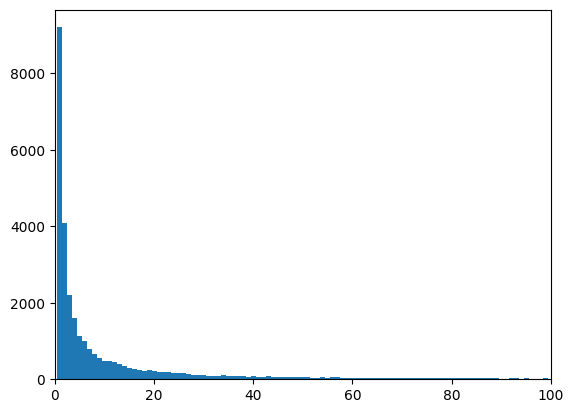

In [ ]:
# 단어 빈도에 따른 히스토그램 그리기
import matplotlib.pyplot as plt

#plot histogram based on freq words
plt.hist(word_freqs.values(), bins=100, range=(0, 100), align="left")
plt.xlim(0, 100)
plt.show()

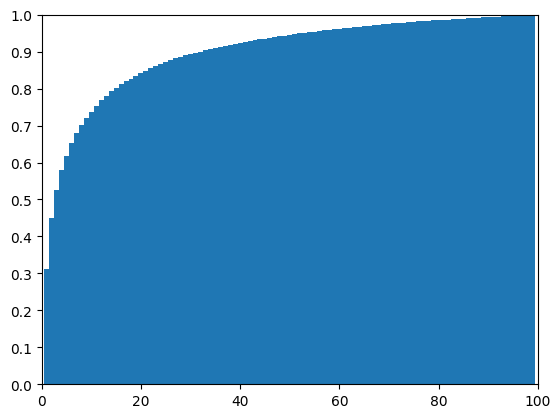

In [ ]:
# 단어 빈도에 따른 히스토그램 그리기
import matplotlib.pyplot as plt

plt.hist(
    word_freqs.values(),
    bins=100,
    range=(0, 100),
    align="left",
    cumulative=True, #based on cumulative word freq n density
    density=True,
)
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.yticks([i / 10 for i in range(11)]) #
plt.show()

In [ ]:
#build vocab list
#only take only word not freq coz in word_freq have like [word, 12202] only take word
vocab = [word for word, _ in word_freqs.most_common(10000)]

#take that and make index for each vocab
word2idx = {word: idx for idx, word in enumerate(vocab)}

In [ ]:
from scipy.sparse import dok_matrix
import numpy as np

#empty sparse matrix, dok format(dict of key)
dtm = dok_matrix((len(document_tokens_list), len(vocab)), dtype=np.float32)
# to make matrix only with non-zero entery, save memory.

#count word freqin doc
for doc_idx, (_, tokens) in enumerate(tqdm(document_tokens_list, mininterval=1)):
    for token in tokens: #each word in doc
        try:
            word_idx = word2idx[token]
            #build bag of word use that word
            dtm[doc_idx, word_idx] += 1
        except KeyError:
            pass

dtm = dtm.tocsr() # compressed to sparse row , for faster model train
print(dtm.shape) #7880, 10000, 7880 docs, 10000 word in vocab

100%|██████████| 7880/7880 [00:12<00:00, 614.66it/s]

(7880, 10000)


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

#make tfidf
tfidf = TfidfTransformer()
tfidf_matrix = tfidf.fit_transform(dtm) #perform tfidf on dtm 

In [ ]:
from sklearn.decomposition import NMF

#set num topic = k = 10 nmf matrix n*k *k*m shape
num_topics = 10
nmf = NMF(n_components=num_topics, max_iter=1000, shuffle=True, random_state=42) #make nmf

W = nmf.fit_transform(tfidf_matrix) #perform nmf on tfidf matrix - w = n = doc term matrix
H = nmf.components_ # h = m = topic term matrix

print(nmf.n_iter_) #iter till convergence 149 iter
print(W.shape, H.shape) # shape n*k k*m

149
(7880, 10) (10, 10000)


In [ ]:
# Topic 별로 가장 가중치 높은 단어 20개 출력
#print each topic and word that top 20 foreach topic
for topic_idx in range(num_topics):
    #get index of top 20 word
    top_word_indices = H[topic_idx].argsort()[::-1][:20]
    
    #take index and convert to its word back 
    top_words = [vocab[idx] for idx in top_word_indices]

    #print that words
    print(f"Topic #{topic_idx}: {', '.join(top_words)}")
    print()

Topic #0: 미국, 관세, 트럼프, 협상, 한미, 회담, 북한, 중국, 잠수함, 한국, 대통령, 합의, 투자, 타결, 정상, 안보, 무역, 건조, 외교, 추진

Topic #1: AI, 엔비디아, 기술, 데이터, 산업, GPU, 기업, 구축, 한국, 혁신, 협력, 인프라, 반도체, 투자, 센터, 글로벌, 기반, 네이버, 개발, 피지컬

Topic #2: 경주, 도시, 시민, 문화, APEC, 관광, 행사, 회의, 정상, 경북, 세계, 경주시, 경북도, 개최, 성공, 국제, 이번, 신라, 운영, 역사

Topic #3: 회장, CEO, 서밋, 그룹, 참석, 기업, 최태원, 이재용, 젠슨 황, 글로벌, 기업인, APEC, 삼성전자, 정의선, 행사, RM, 연설, 총수, 엔비디아, 부회장

Topic #4: 국민, 대통령, 국회, 민주당, 대표, 재판, 성과, 조사, 정부, 의원, 예산, 원내, 국정, 외교, 이재명, 지지, 중지, 평가, 예산안, 정쟁

Topic #5: 수소, 현대차그룹, 모빌리티, 에너지, 버스, 전기, SK이노베이션, 생산, PBV, 글로벌, 넥쏘, 기술, 부회장, 미래, LNG, 산업, 환경, 전시, 서밋, CEO

Topic #6: APEC, 협력, 인구, 선언, 무역, 공동, 변화, 성장, 경제, 회원, 구조, 채택, AI, 번영, 회의, 대응, 정상, 혁신, 경주, 창조

Topic #7: 뷰티, 브랜드, 선물, 올리브, 제품, 푸드, LG생활건강, 체험, 배우자, 화장품, 제공, 한국, 글로벌, 환유고, 더후, 환유, 패키지, 선보이, 식품, 전통

Topic #8: 지드래곤, 공연, 만찬, 차은우, 환영, 무대, 문화, 가수, APEC, 영상, 홍보, 정상, 대사, 음악, 아티스트, 호텔, RM, 한국, 회의, 전통

Topic #9: 대통령, 총리, 정상, 회담, 주석, 중국, 다카이치, 일본, 관계, 양국, 시진핑, 회의, 트럼프, 방한, 이재명, 국가주석, 일정, 경주, 황남빵, 협력



In [ ]:
# Topic 별로 가장 가중치 높은 문서 5개 출력
#print top 5 document
for topic_idx in range(num_topics):

    #get index of top 5 doc
    top_doc_indices = W[:, topic_idx].argsort()[::-1][:5]

    print(f"Topic #{topic_idx}:")
    for doc_idx in top_doc_indices:
        #find that index doc and print first 100 word
        print(f"Doucment #{doc_idx}: {document_tokens_list[doc_idx][0][:100]}")
    print()

Topic #0:
Doucment #6852: 상호관세 15% 유지, 자동차 관세도 일본과 동일하게 15%
한미 정상회담 주요 내용
불확실성 뚫고 관세 극적 합의
대미 투자 원금 회수 장치 마련
의약품·목재 분야 최혜국 대우

Doucment #173: 미국 백악관이 지난달 말 도널드 트럼프 대통령의 4박 5일 간 아시아 순방 이후 한국과 무역 합의에 대한 팩트시트(자료집) 발표만 유독 미루고 있어 그 배경에 관심이 쏠리고 있다.
Doucment #4693: 박원곤 이화여대 북한학과 교수 대담
한미·한중·한일 숨가빴던 복합외교
트럼프 "필리조선소서 원잠 만들라"
인프라 없어 건조 불확실성만 키워
中 "韓, 핵비확산 체제 위반" 발언
북
Doucment #874: 오랫동안 협상해 온 한미 관세 협상이 타결되었다. 지난 10월 트럼프 미국 대통령이 방한해 한미 정상회담이 열렸고 관세 협상이 타결된 것이다. 이번에 관세 협상 타결에 대해 전반적
Doucment #1944: 지난 한 주 세계의 시선을 모았던 '외교 슈퍼위크'가 끝났다. 아세안 정상회의를 시작으로 한미 정상회담과 APEC(아시아‧태평양경제협의체) 정상회의를 거쳐 한중 정상회담까지. 숨 

Topic #1:
Doucment #4842: 李 대통령 "韓, 아·태 AI 수도 목표…AI 생태계 함께 만들어가길"
글로벌 AI 기술협력 논의…삼성·현대차·SK·네이버 등 기업총수들 한 자리에
"'AI 3대 강국', 'AI 
Doucment #735: 한국 정부와 산업계, 그리고 엔비디아 간 인공지능(AI) 동맹이 본격화한다. 엔비디아는 전 세계적으로 공급이 달리는 그래픽처리장치(GPU) 26만 장을 향후 5년간 한국에 공급하고
Doucment #26: 경주 APEC 2025가 성황리에 끝났다. 한국은 물론 아시아 태평양 전체에 시사하는 바가 큰 가운데, 경주 APEC 2025의 결정적 순간을 키워드로 살펴본다.
키워드 : #엔비
Doucment #1992: 경주에서 지난달 28일부터 31일까지 열린 아시아태평양경제

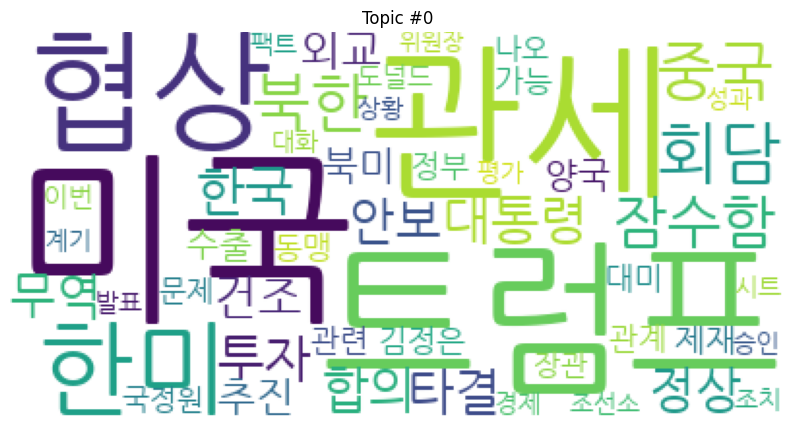

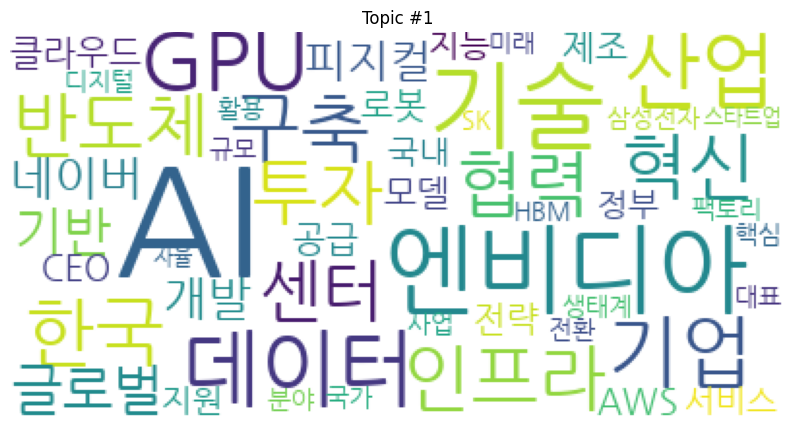

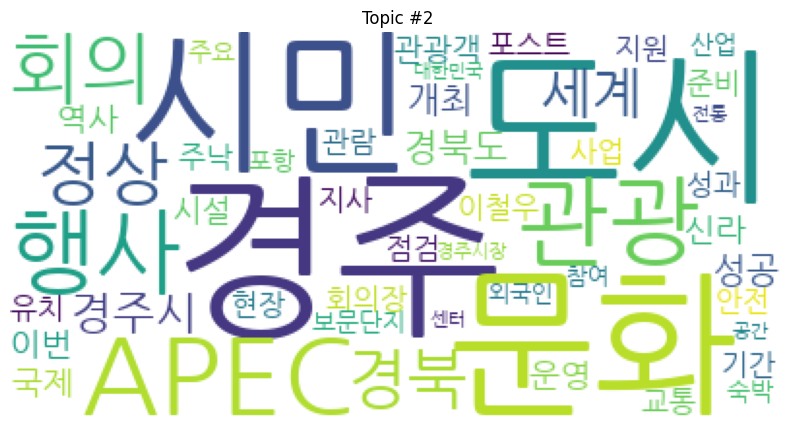

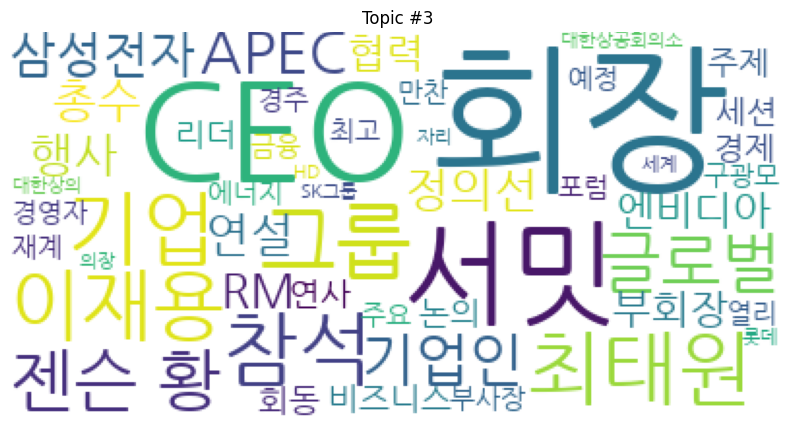

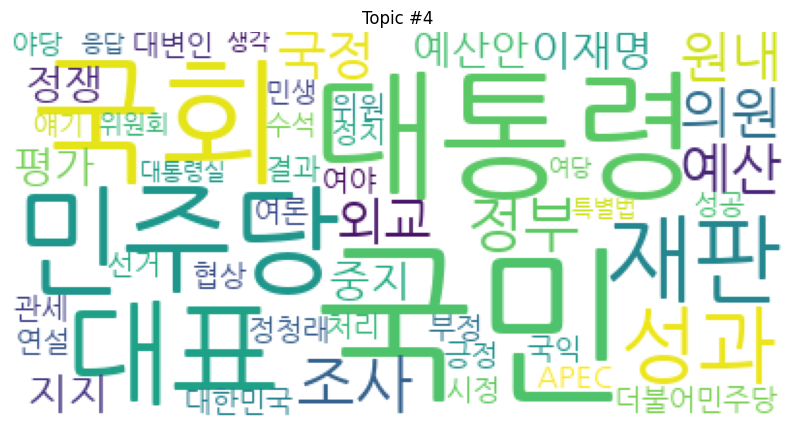

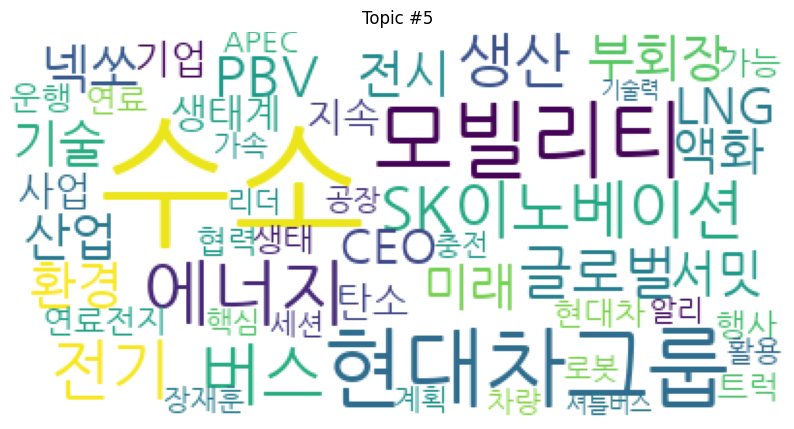

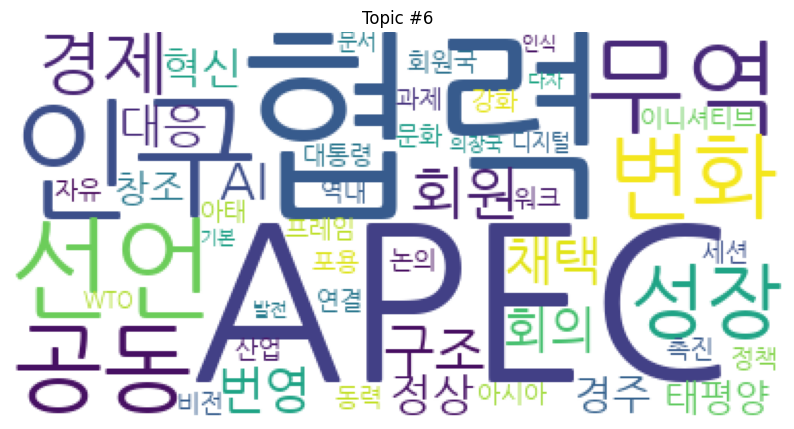

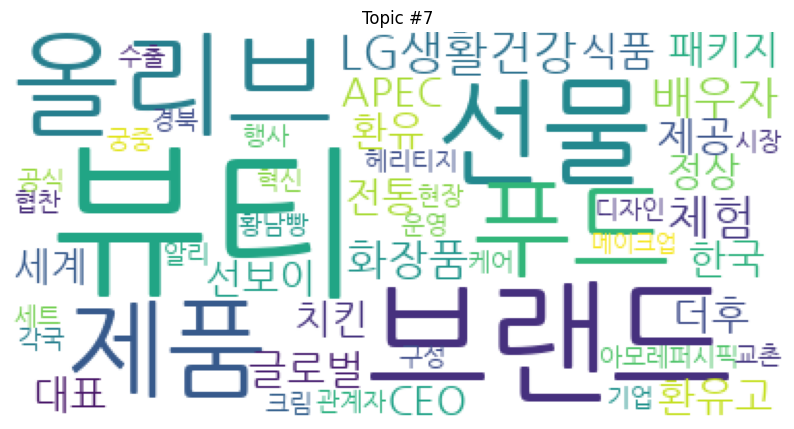

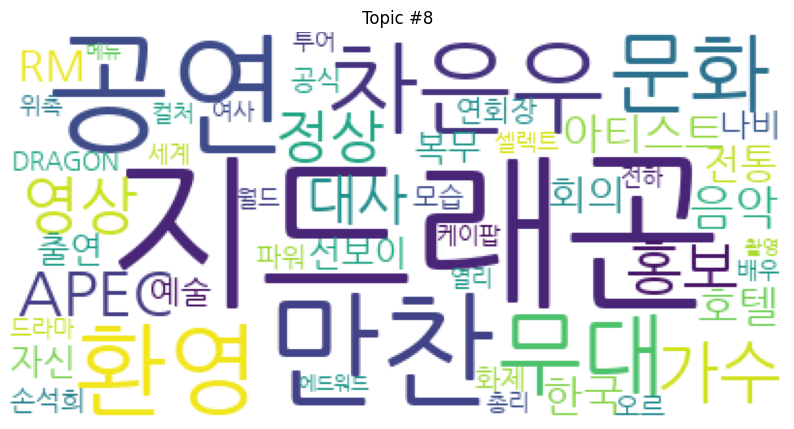

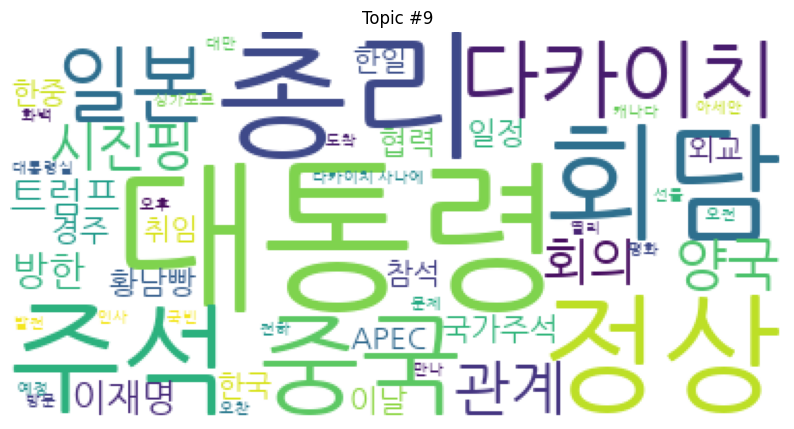

In [ ]:
# 각 토픽별 워드 클라우드 생성

from wordcloud import WordCloud
import matplotlib.pyplot as plt

for topic_idx in range(num_topics):
    num_top_words = 50
    top_word_indices = H[topic_idx].argsort()[::-1][:num_top_words]

    word_weights = {
        #take topic top word from the top indices
        vocab[word_idx]: H[topic_idx, word_idx] for word_idx in top_word_indices
    }

    wc = WordCloud(
        font_path="/usr/share/fonts/truetype/nanum/NanumGothic.ttf",
        prefer_horizontal=1.0,
        background_color="white",
        margin=1,
    )
    wc.generate_from_frequencies(word_weights) #generate from freq weight word

    plt.figure(figsize=(10, 10))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Topic #{topic_idx}")
    plt.show()

In [ ]:
# scatter plot 그리기

from sklearn.manifold import TSNE

#dimension reduce to 2
tsne = TSNE(n_components=2, max_iter=2000, random_state=42, n_jobs=-1, verbose=2)
W2 = tsne.fit_transform(W) #perform it to document

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7880 samples in 0.004s...
[t-SNE] Computed neighbors for 7880 samples in 0.160s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7880
[t-SNE] Computed conditional probabilities for sample 2000 / 7880
[t-SNE] Computed conditional probabilities for sample 3000 / 7880
[t-SNE] Computed conditional probabilities for sample 4000 / 7880
[t-SNE] Computed conditional probabilities for sample 5000 / 7880
[t-SNE] Computed conditional probabilities for sample 6000 / 7880
[t-SNE] Computed conditional probabilities for sample 7000 / 7880
[t-SNE] Computed conditional probabilities for sample 7880 / 7880
[t-SNE] Mean sigma: 0.009456
[t-SNE] Computed conditional probabilities in 0.099s
[t-SNE] Iteration 50: error = 81.1480331, gradient norm = 0.0202397 (50 iterations in 0.812s)
[t-SNE] Iteration 100: error = 75.8761139, gradient norm = 0.0042936 (50 iterations in 0.567s)
[t-SNE] Iteration 150: error = 74.5189896, gradient norm = 0

In [ ]:
from collections import defaultdict
from bokeh.plotting import figure, show, output_file
from bokeh.palettes import Category10
from bokeh.models import HoverTool, ColumnDataSource

output_file("t-sne.html")

topic_idx_per_document = W.argmax(axis=1)
document_idx_per_topic = defaultdict(list)

#keep local structure based on each topic. same topic same color but in reduce dimen
source_per_topic = {}
for doc_idx, topic_idx in enumerate(topic_idx_per_document):
    document_idx_per_topic[topic_idx].append(doc_idx)
    source_per_topic[topic_idx] = ColumnDataSource(
        data=dict(
            x=W2[document_idx_per_topic[topic_idx], 0], # topic no
            y=W2[document_idx_per_topic[topic_idx], 1],
            text=[
                document_tokens_list[doc_idx][0][:100]
                for doc_idx in document_idx_per_topic[topic_idx] #doc data news data
            ],
        )
    )
    
p = figure(title="t-SNE scatter plot") # make scatter plot based on that
p.width = 960
p.height = 720
p.add_tools(HoverTool(tooltips=[("기사", "@text")], attachment="right")) #can hover see what news on that topic
for topic_idx, source in source_per_topic.items():
    p.scatter(
        x="x",
        y="y",
        source=source,
        size=5,
        fill_alpha=0.5,
        legend_label=f"Topic #{topic_idx}",#can hover see what news on that topic
        color=Category10[10][topic_idx],
    )

p.legend.location = "top_right"
show(p)

0:96: execution error: 일부 대상체 파일을 발견할 수 없습니다. (-43)
